# Models analysis notebook

This notebook presents a comparative analysis of several machine learning models for monthly deal prediction. Linear Regression, Random Forest, and XGBoost will be evaluated as the primary approaches. The main goal is to select the best-performing model based on MAPE and visualize the results, including feature importance and out-of-sample forecasting. All results are documented for transparency and reproducibility.


### Let's choose the model.

               Model       MAPE
0  Linear Regression  80.767817
1      Random Forest   7.911734
2            XGBoost   5.389688


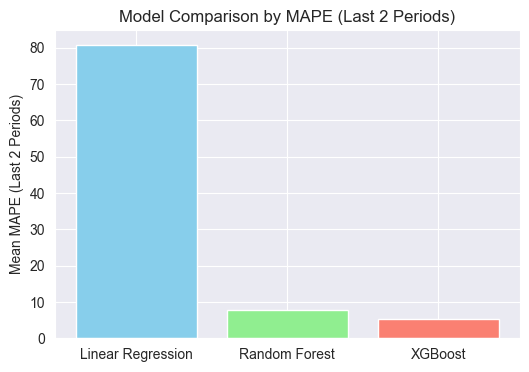

In [1]:
import sys
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent))
from scripts.validate_model import validate_model
from src.rawdata import RawData
from src.model_validator import ModelValidator
from src.features import Features
from scripts.predict_target import predict_target
from scripts.save_model import save_model

linreg_results = validate_model(model=LinearRegression(), data_path="../data/raw_data.csv", target="Deals")
rf_results = validate_model(model=RandomForestRegressor(random_state=42), data_path="../data/raw_data.csv", target="Deals")
xgb_results = validate_model(model=XGBRegressor(random_state=42), data_path="../data/raw_data.csv", target="Deals")

linreg_results['Model'] = 'Linear Regression'
rf_results['Model'] = 'Random Forest'
xgb_results['Model'] = 'XGBoost'

linreg_last2 = linreg_results.tail(2)
rf_last2 = rf_results.tail(2)
xgb_last2 = xgb_results.tail(2)
all_last2 = pd.concat([linreg_last2, rf_last2, xgb_last2], ignore_index=True)

mape_summary_last2 = all_last2.groupby('Model')['MAPE'].mean().reset_index()
print(mape_summary_last2)

plt.figure(figsize=(6,4))
plt.bar(mape_summary_last2['Model'], mape_summary_last2['MAPE'], color=['skyblue','lightgreen','salmon'])
plt.ylabel('Mean MAPE (Last 2 Periods)')
plt.title('Model Comparison by MAPE (Last 2 Periods)')
plt.savefig("main_plots/models_MAPE.png", bbox_inches="tight", dpi=200)
plt.show()

### Now we can check preictions in comparison with real deals.

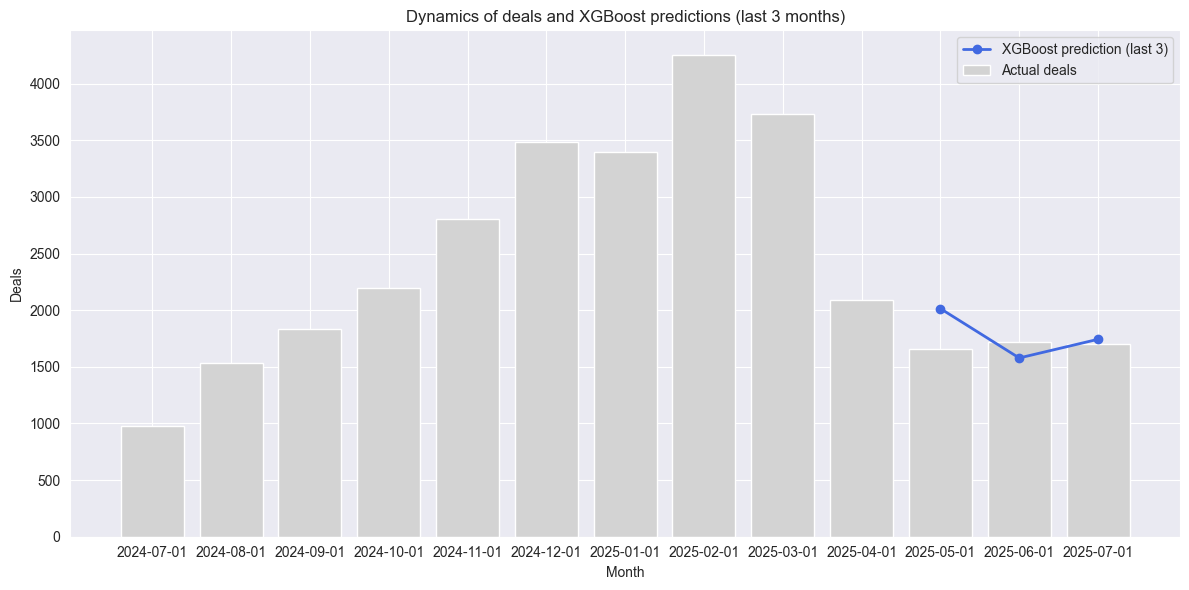

In [2]:
fact = RawData(file_path="../data/raw_data.csv").target("Deals")
last_months = fact['Month'].iloc[-3:]
xgb_results = validate_model(
    model=XGBRegressor(random_state=42),
    data_path="../data/raw_data.csv",
    target="Deals"
)
preds = xgb_results['Predicted'].values[-3:]

plt.figure(figsize=(12,6))
plt.bar(fact['Month'].astype(str), fact['Deals'], color='lightgrey', label='Actual deals')
plt.plot(last_months.astype(str), preds, color='royalblue', marker='o', linewidth=2, label='XGBoost prediction (last 3)')
plt.title("Dynamics of deals and XGBoost predictions (last 3 months)")
plt.xlabel("Month")
plt.ylabel("Deals")
plt.legend()
plt.tight_layout()
plt.show()

### But some features may be the most important. Let's find them.

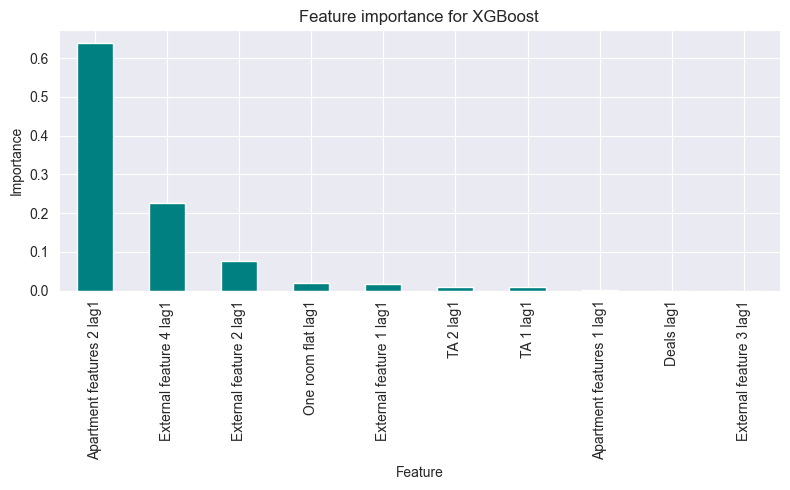

In [3]:
X = (
    Features(
        RawData("../data/raw_data.csv")
        .make_features()
    )
    .add_sin_seasonality(period=12)
    .add_cos_seasonality(period=12)
    .prepare_data()
)
X = X.drop(columns=['Month'], errors='ignore')
feature_names = X.columns
y = RawData("../data/raw_data.csv").target("Deals")
y = y.drop(columns=['Month'], errors='ignore')

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X, y)
importances = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.head(10).plot(kind='bar', color='teal')
plt.title('Feature importance for XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.savefig("main_plots/features.png", bbox_inches="tight", dpi=200)
plt.show()

### I want to compare two models: first model with all features and second - with top 8 features.

Full model (last 2 months):
  TrainPart  Actual    Predicted      MAPE
2     10/12    1720  1578.034668  8.253798
3     11/12    1700  1742.934814  2.525577
Mean MAPE: 5.39%

Model with top 8 features (last 2 months):
  TrainPart  Actual    Predicted       MAPE
2     10/12    1720  1537.001343  10.639457
3     11/12    1700  1720.139771   1.184692
Mean MAPE: 5.91%
Model without features (last 2 months):
  TrainPart  Actual    Predicted       MAPE
2     10/12    1720  1537.001953  10.639421
3     11/12    1700  1719.892334   1.170137
Mean MAPE: 5.90%


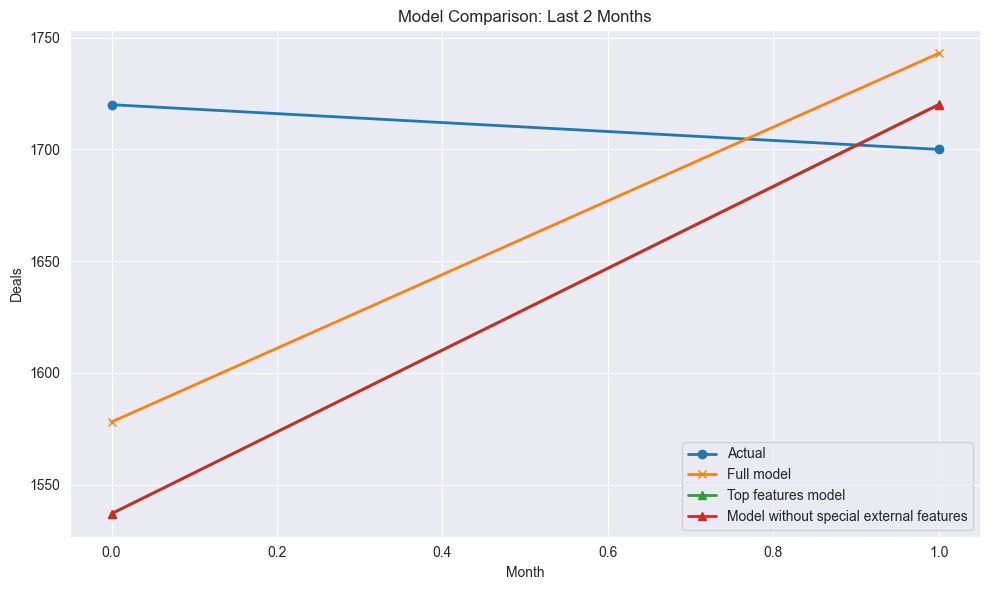

In [4]:
special_external_features = ["External feature 1 lag1", "External feature 2 lag1"]
top_features_list = ["Apartment features 2 lag1", "Apartment features 1 lag1", "External feature 4 lag1", "External feature 2 lag1",
                     "One room flat lag1", "External feature 1 lag1", "TA 2 lag1", "TA 1 lag1"]

results_full = (
    ModelValidator(
        XGBRegressor(random_state=42),
        (
            Features(
                RawData("../data/raw_data.csv")
                .make_features()
            )
            .add_sin_seasonality(period=12)
            .add_cos_seasonality(period=12)
            .prepare_data()
        )
    ).validate(
        RawData("../data/raw_data.csv")
        .target("Deals")
    )
)

results_top = (
    ModelValidator(
        XGBRegressor(random_state=42),
        (
            Features(
                RawData("../data/raw_data.csv")
                .make_features()
            )
            .add_sin_seasonality(period=12)
            .add_cos_seasonality(period=12)
            .choose_features(top_features_list)
            .prepare_data()
        )
    ).validate(
        RawData("../data/raw_data.csv")
        .target("Deals")
    )
)

results_ext = (
    ModelValidator(
        XGBRegressor(random_state=42),
        (
            Features(
                RawData("../data/raw_data.csv")
                .make_features()
            )
            .add_sin_seasonality(period=12)
            .add_cos_seasonality(period=12)
            .drop_features(special_external_features)
            .prepare_data()
        )
    ).validate(
        RawData("../data/raw_data.csv")
        .target("Deals")
    )
)

results_full_last2 = results_full.tail(2)
results_top_last2 = results_top.tail(2)
results_ext_last2 = results_ext.tail(2)

print("Full model (last 2 months):")
print(results_full_last2 )
print(f"Mean MAPE: {results_full_last2['MAPE'].mean():.2f}%\n")

print("Model with top 8 features (last 2 months):")
print(results_top_last2)
print(f"Mean MAPE: {results_top_last2['MAPE'].mean():.2f}%")

print("Model without features (last 2 months):")
print(results_ext_last2)
print(f"Mean MAPE: {results_ext_last2['MAPE'].mean():.2f}%")

fig, ax = plt.subplots(figsize=(10,6))
months = range(len(results_full_last2))
ax.plot(months, results_full_last2['Actual'].values, marker='o', label='Actual', linewidth=2)
ax.plot(months, results_full_last2['Predicted'].values, marker='x', label='Full model', linewidth=2)
ax.plot(months, results_top_last2['Predicted'].values, marker='^', label='Top features model', linewidth=2)
ax.plot(months, results_ext_last2['Predicted'].values, marker='^', label='Model without special external features', linewidth=2)
ax.set_xlabel('Month')
ax.set_ylabel('Deals')
ax.set_title('Model Comparison: Last 2 Months')
ax.legend()
plt.tight_layout()
plt.show()

### So there is no reason to choose only top features. Lets predict the amount of deals in September.

Model predicts that there will be 1669 deals in september 2025.


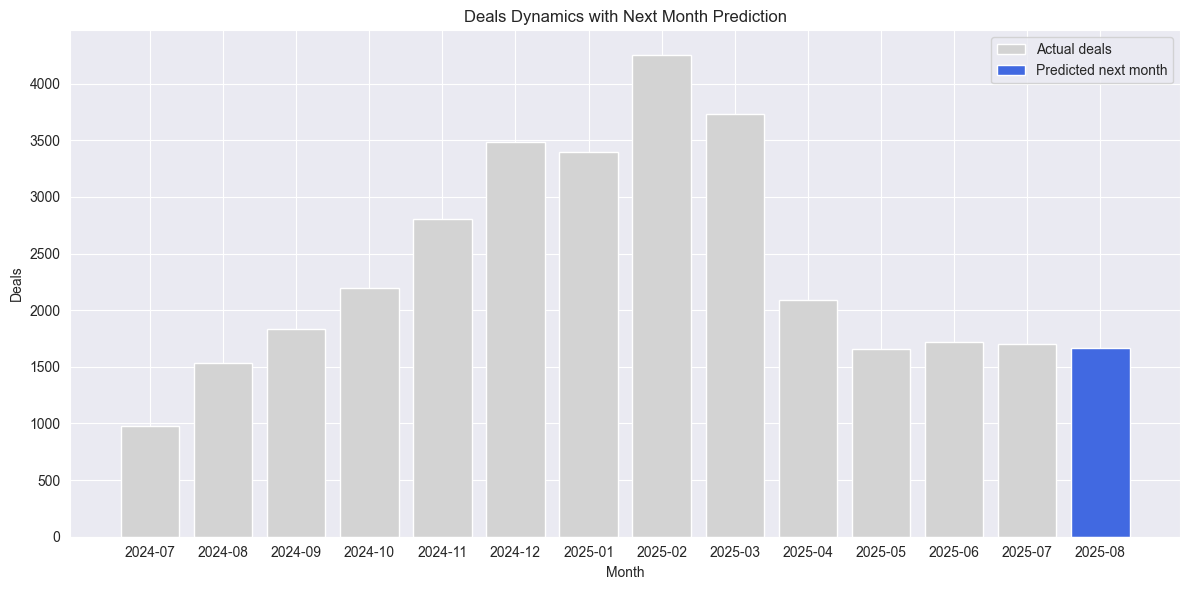

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

df = RawData("../data/raw_data.csv").target("Deals")
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')

deals = df.groupby('Month')['Deals'].sum()

next_month_pred = predict_target(
    model_folder=(
        save_model(
            model=XGBRegressor(),
            data_path="../data/raw_data.csv",
            target="Deals",
            models_folder_path="../saved_models",
            model_name="xgb_model"
        )
    )
)

print(f"Model predicts that there will be {int(next_month_pred)} deals in september 2025.")

next_month = deals.index[-1] + 1
deals_with_pred = deals.copy()
deals_with_pred.loc[next_month] = next_month_pred

plt.figure(figsize=(12,6))
plt.bar(deals.index.astype(str), deals.values, color='lightgrey', label='Actual deals')
plt.bar(str(next_month), next_month_pred, color='royalblue', label='Predicted next month')
plt.title("Deals Dynamics with Next Month Prediction")
plt.xlabel("Month")
plt.ylabel("Deals")
plt.legend()
plt.tight_layout()
plt.savefig("main_plots/prediction.png", bbox_inches="tight", dpi=200)
plt.show()

# Conclusion

In this project, I initially compared three different models and ultimately selected XGBoost﻿ due to its superior performance in demand forecasting.

After training the XGBoost model, I conducted a thorough feature importance analysis. It turned out that 8 features contribute the most to the predictions, with the top 3 including two significant external factors. These external features play a crucial role in influencing demand patterns.

Further experimentation showed that the model trained on all available features consistently outperformed the one limited to the selected subset of top features. This finding underscores the importance of leveraging the full feature set to capture the complex relationships affecting demand.

Finally, the model predicts that in September 2025 there will be approximately 1669 deals.

Please note that my access to updated data has ended, so I encourage you to verify these predictions independently using your own datasets.